In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing the Data

The data is easily acessible without having to parse the files manually from keras deep learning library.

In [95]:
from keras.datasets import mnist

In [96]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Show an image from the training dataset.

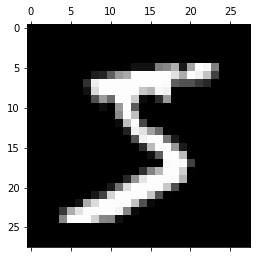

In [97]:
plt.matshow(X_train[0], cmap='gray')

Get the shape of the data

In [98]:
X_train.shape

(60000, 28, 28)

In [99]:
X_test.shape

(10000, 28, 28)

Reshape the data into 60k rows by 784 columns.

In [100]:
X_train = np.reshape(X_train, (X_train.shape[0],28*28))
X_test = np.reshape(X_test, (X_test.shape[0],28*28))

In [101]:
X_train.shape

(60000, 784)

In [102]:
def vectorize(num):
    vec=np.zeros(10)
    vec[num]=1
     
    return vec

In [103]:
y_train = (pd.Series(y_train).apply(vectorize)).to_numpy()
y_train = np.stack(y_train)

In [104]:
y_test = (pd.Series(y_test).apply(vectorize)).to_numpy()
y_test = np.stack(y_test)

Now each row of A (X_train) can have a mapping to B (y_train) through x.

# Problem 1

## Least Squares (Minimizing 2-norm):

First trying a linear least squares solution (minimizing the 2-norm):

In [105]:
x = np.linalg.lstsq(X_train, y_train, rcond=None)

In [106]:
X_train.shape

(60000, 784)

I can plot the image along with the true label and the label found by least squares solution.  
On the bottom left is the true label.   
On the bottom right is the model response label.

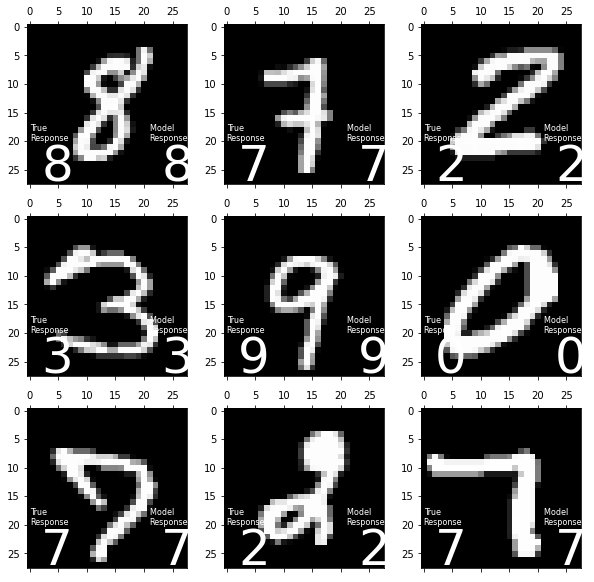

In [107]:
plt.figure(figsize=[10,10])
for i in np.arange(1,10):
    plt.subplot(3,3,i)
    check = np.random.randint(0,X_train.shape[0])
    plt.matshow(X_train[check].reshape(28,28), fignum=False, cmap='gray')
    plt.text(23,27,(X_train@x[0])[check].argmax(), fontsize=50, c='white')
    plt.text(2,27,y_train[check].argmax(), fontsize=50, c='white')
    plt.text(21,20,'Model \nResponse', fontsize=8, c='white')
    plt.text(0,20,'True \nResponse', fontsize=8, c='white')

### Test Set Performance:

Lets see how accurate the least square solve is:

In [108]:
y_pred = (X_test@x[0]).argmax(axis=1)
y_true = y_test.argmax(axis=1)

In [109]:
len([x for x in y_true-y_pred if x == 0]) / len(y_true)

0.8534

85% classification accuracy on the test set.  
I'll also plot a matrix of images with true and model responses from the test set.

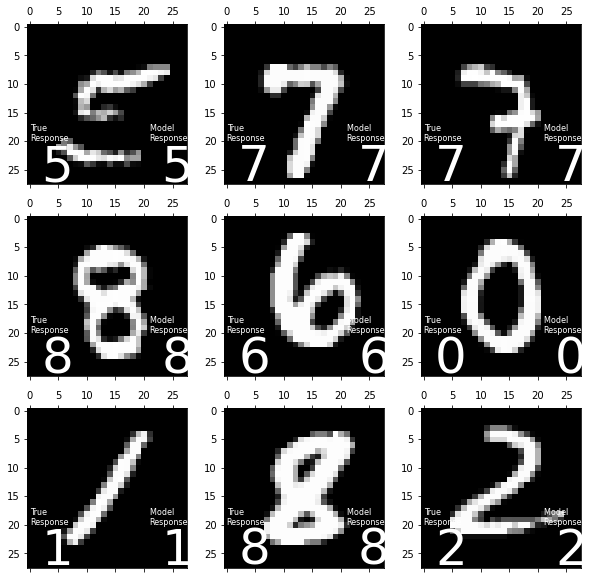

In [110]:
plt.figure(figsize=[10,10])
for i in np.arange(1,10):
    plt.subplot(3,3,i)
    check = np.random.randint(0,X_test.shape[0])
    plt.matshow(X_test[check].reshape(28,28), cmap='gray', fignum=False)
    plt.text(23,27,(X_test@x[0])[check].argmax(), fontsize=50, c='white')
    plt.text(2,27,y_test[check].argmax(), fontsize=50, c='white')
    plt.text(21,20,'Model \nResponse', fontsize=8, c='white')
    plt.text(0,20,'True \nResponse', fontsize=8, c='white')

In this case the mapping between the image space and the label space is a matrix of coefficients with shape 784x10.  
Many coefficients are not 0.

In [155]:
print('number of non-zero coefficients',len([x for x in x[0].flatten() if x != 0]))

number of non-zero coefficients 7700


## Minimizing the 1-Norm (Lasso)

Lasso regression promotes sparsity in the coefficients of a linear regression model.

In [111]:
from sklearn.linear_model import Lasso

In [112]:
# instantiate a Lasso regressor
lr = Lasso()

# fit the lasso regressor to the data
lr.fit(X_train,y_train)

# predict on the test set
y_pred = lr.predict(X_test).argmax(axis=1)

In [113]:
# Get Classification Accuracy
len([x for x in y_true-y_pred if x == 0]) / len(y_true)

0.831

85% accuracy on the test set. This shows that regularization was useful. We still dont know if the problem could use more or less regularization. The lasso model minimizes the following:

$\min_{w} { \frac{1}{2n_{\text{samples}}} ||X w - y||_2 ^ 2 + \alpha ||w||_1}$

Note that the $\alpha$ parameter defines the amount of regularization to use. I'll use cross validation to find a good value for $\alpha$.

The other trouble here is that we are using a regression solver but we are ultimately interested in the model's ability to classify images of handwritten numbers correctly. This is a classification problem at the end of the day. So, I will implement a custom scoring function in the cross validation to address this unique accuracy measure.

In [114]:
from sklearn.metrics import make_scorer

# Define a scoring function that computes multi-class classification accuracy
def my_custom_loss_func(y_true, y_pred):
    
    y_pred = y_pred.argmax(axis=1)
    y_true = y_true.argmax(axis=1)
    
    return len([x for x in y_true-y_pred if x == 0]) / len(y_true)

# create a scikit-learn scorer using the custom loss function
my_scorer = make_scorer(my_custom_loss_func, greater_is_better=True)

In [115]:
from sklearn.model_selection import GridSearchCV

# build models with different values of alpha
parameters = {'alpha':[.00001,.0001,.001,.01,.1,.5,1,2]}

# instantiate a grid search cross validator with 3 folds per parameter selection
clf = GridSearchCV(lr, parameters, n_jobs=6, cv=2, verbose=10, scoring=my_scorer)

# fit the cross validator to the training set
clf.fit(X_train, y_train)

results_df = pd.DataFrame(clf.cv_results_)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  6.2min
[Parallel(n_jobs=6)]: Done   7 out of  16 | elapsed: 10.2min remaining: 13.1min
[Parallel(n_jobs=6)]: Done   9 out of  16 | elapsed: 10.6min remaining:  8.2min
[Parallel(n_jobs=6)]: Done  11 out of  16 | elapsed: 10.8min remaining:  4.9min
[Parallel(n_jobs=6)]: Done  13 out of  16 | elapsed: 11.2min remaining:  2.6min
[Parallel(n_jobs=6)]: Done  16 out of  16 | elapsed: 11.8min finished


I can plot a bias-variance curve that shows that as we increase alpha, the model begins to miss important information (too much regularization). If alpha is too low, the model does not have enough regularization and has higher variance.

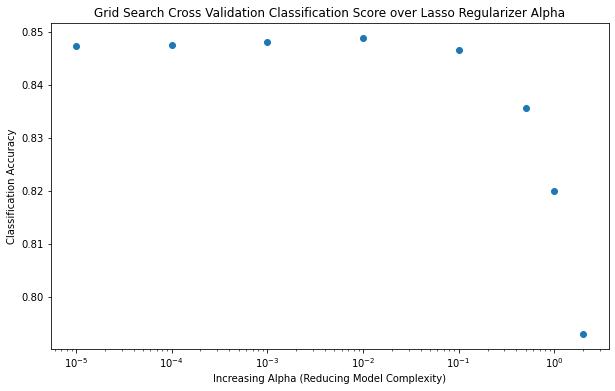

In [128]:
plt.figure(figsize=[10,6])
plt.scatter(results_df['param_alpha'], results_df['mean_test_score'])
plt.title('Grid Search Cross Validation Classification Score over Lasso Regularizer Alpha');
plt.ylabel('Classification Accuracy'); plt.xlabel('Increasing Alpha (Reducing Model Complexity)');
plt.xscale('log')

It looks like $\alpha$ of .01 is appropriate.  
I'll build a final Lasso Regression model with an $\alpha$ of .01.

In [124]:
# instantiate a Lasso regressor
lr = Lasso(alpha=.01)

# fit the lasso regressor to the data
lr.fit(X_train,y_train)

# predict on the test set
y_pred = lr.predict(X_test).argmax(axis=1)

### Test Set Performance

In [125]:
len([x for x in y_true-lr.predict(X_test).argmax(axis=1) if x == 0]) / len(y_true)

0.8612

We get a 1% boost in classification accuracy performace by reducing model variance using regularization.

I can visualize the mapping from image space to label space by looking at the lasso regression coefficients.  

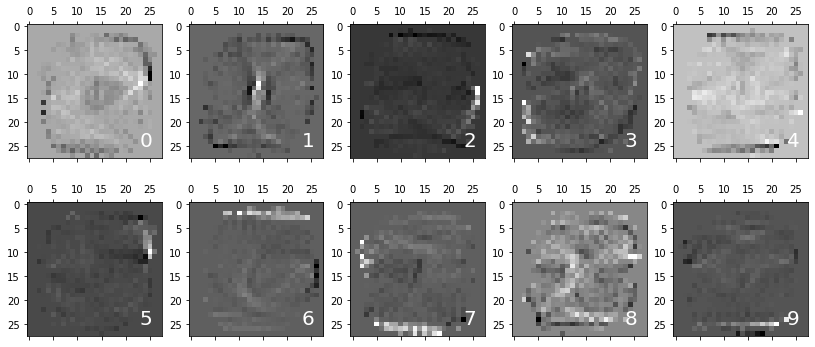

In [143]:
plt.figure(figsize=[14,6])
for i in np.arange(0,10):
    plt.subplot(2,5,i+1)
    plt.matshow(lr.coef_[i].reshape(28,28), fignum=False, cmap='gray')
    plt.text(23,25,i, fontsize=20, c='white')

# Problem 2

The Lasso Regressor built in problem 1 is appropriate for promoting sparsity. It drives many coefficients to 0, especially as alpha increases. The metric for determining how important a pixel is can be determined by the magnitude of the coefficient for that given pixel.

In [177]:
print('number of non-zero coefficients',len([x for x in lr.coef_.flatten() if x != 0]))

number of non-zero coefficients 4106


In [187]:
print('% coefficients not zero = ',np.round(len([x for x in lr.coef_.flatten() if x != 0])/len(lr.coef_.flatten())*100,2))

% coefficients not zero =  52.37


Depending on the priority of speed vs accuracy, more regularization could drive more zero coefficients but at an increasing cost of accuracy. I'll increase regularization to $\alpha =1$ and see the tradeoff.

In [178]:
# instantiate a Lasso regressor
lr_a1 = Lasso(alpha=1)

# fit the lasso regressor to the data
lr_a1.fit(X_train,y_train)

print('Classification Accuracy:',len([x for x in y_true-lr_a1.predict(X_test).argmax(axis=1) if x == 0]) / len(y_true))

Classification Accuracy: 0.831


In [179]:
print('number of non-zero coefficients',len([x for x in lr_a1.coef_.flatten() if x != 0]))

number of non-zero coefficients 833


In [186]:
print('% coefficients not zero = ',np.round(len([x for x in lr_a1.coef_.flatten() if x != 0])/len(lr_a1.coef_.flatten())*100,2))

% coefficients not zero =  10.62


We get a 3 percentage point reduction in test set accuracy, but we also drive many more coefficients to 0.

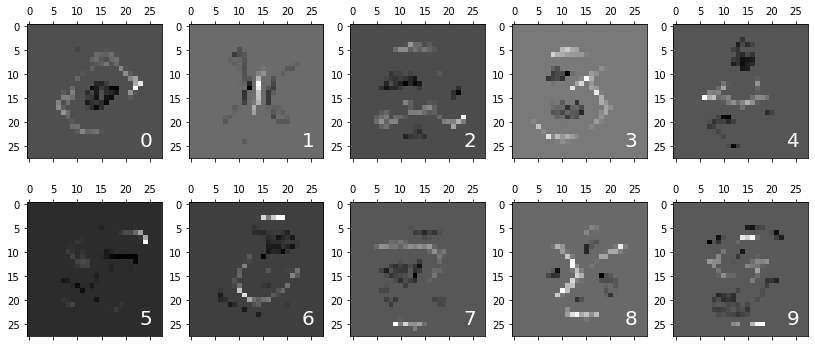

In [181]:
plt.figure(figsize=[14,6])
for i in np.arange(0,10):
    plt.subplot(2,5,i+1)
    plt.matshow(lr_a1.coef_[i].reshape(28,28), fignum=False, cmap='gray')
    plt.text(23,25,i, fontsize=20, c='white')

I made a bias-variance curve already in part 1, so we already know we will be taking an accuracy hit going above $\alpha=.01$ but lets see what the visualization of coefficients looks like with an $\alpha=3$

In [182]:
# instantiate a Lasso regressor
lr_a3 = Lasso(alpha=3)

# fit the lasso regressor to the data
lr_a3.fit(X_train,y_train)

print('Classification Accuracy:',len([x for x in y_true-lr_a3.predict(X_test).argmax(axis=1) if x == 0]) / len(y_true))

Classification Accuracy: 0.7684


In [183]:
print('number of non-zero coefficients',len([x for x in lr_a3.coef_.flatten() if x != 0]))

number of non-zero coefficients 369


In [184]:
print('% coefficients not zero = ',np.round(len([x for x in lr_a3.coef_.flatten() if x != 0])/len(lr_a3.coef_.flatten())*100,2))

% coefficients not zero =  4.71


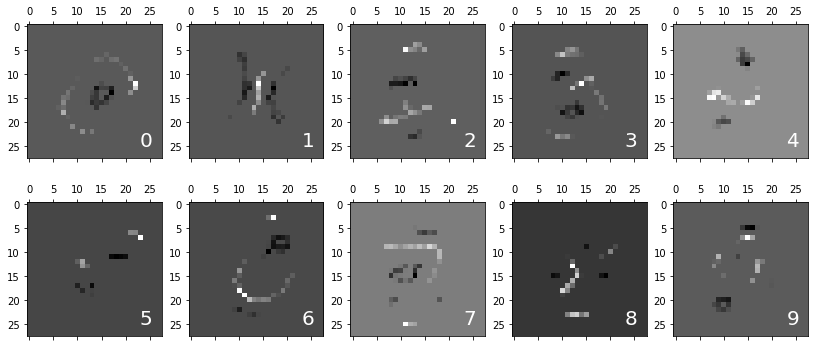

In [185]:
plt.figure(figsize=[14,6])
for i in np.arange(0,10):
    plt.subplot(2,5,i+1)
    plt.matshow(lr_a3.coef_[i].reshape(28,28), fignum=False, cmap='gray')
    plt.text(23,25,i, fontsize=20, c='white')

We took a big hit in accuracy,and we only reduced the % of coefficients that are not zero by 5% from the $\alpha=1$ model.  
I think $\alpha=1$ is a nice tradeoff between test set accuracy and regularization. With a classification accuracy of 83% using only 10% of the pixels.

PUT RANK OF PIXELS HERE!!

# Problem 3